

# **YOLO object detection**

## **Elahe Khodaverdi - Fereshte Bagheri**

## **Description**
In this project, we implement a solution to detect objects in images using the YOLO (You Only Look Once) object detection algorithm. The system can process static images and provide bounding boxes with labels and confidence scores for each detected object. The functionalities include loading input images, running object detection, and saving the processed results to an output folder.

## **Requirements**
- **Libraries**: OpenCV, NumPy, Matplotlib
- **File Structure**:
  - Input images stored in `images/`
  - Output images saved in `outputImages/`
  - Model files (YOLO weights, config, and labels) stored in `models/`

## **Outputs**
### **Expected Outputs**
1. **Images**:
   - Original input images
   - Processed images with detected objects, bounding boxes, and class labels overlaid
2. **Videos**:
   - This project currently processes only static images, but similar functionality can be extended to videos.
3. **Webcam Streams**:
   - This project focuses on image input; real-time webcam detection is not implemented, but the methodology can be extended.

### **Sample Outputs**
- Sample processed images will be available in the `outputImages/` directory after execution. These images will show the detected objects with bounding boxes and their respective confidence scores.

## **Algorithm Details**
1. **YOLO Object Detection**:
   - The system loads a pre-trained YOLO model using the configuration and weight files (`yolov3.cfg` and `yolov3.weights`) to perform object detection on the input image.
   - The image is processed through the YOLO model, which generates predictions for the detected objects.
2. **Bounding Box Generation**:
   - The system uses the output of the YOLO model to extract the bounding box coordinates (center, width, and height) for each detected object.
   - Confidence scores for each detection are used to filter out weak predictions.
3. **Non-Maximum Suppression**:
   - To eliminate overlapping bounding boxes, non-maximum suppression is applied to retain only the most confident predictions.
4. **Object Labeling and Visualization**:
   - Each detected object is labeled with its class (e.g., "person", "car") and a confidence score, which is overlaid on the original image.
   - A random color is assigned to each object class to distinguish between different classes in the image.
5. **Saving Processed Image**:
   - The processed image with the bounding boxes and labels is saved to the `outputImages/` folder in BGR format.


# Requirements

In [50]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
import os

# Loading Models

In [51]:
IMAGE_ADDRESS = os.path.join("images", "image1.jpg")
YOLO_WEIGHT = os.path.join("models", "yolov3.weights")
YOLO_CONFIG_PATH = os.path.join("models", "yolov3.cfg")
YOLO_LABELES_PATH = os.path.join("models", "coco.names")
CONFIDENCE = 0.5
THRESHOLD = 0.3

# load our YOLO object detector trained on COCO dataset (80 classes)
net = cv2.dnn.readNetFromDarknet(YOLO_CONFIG_PATH, YOLO_WEIGHT)

LABELS = open(YOLO_LABELES_PATH).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

# Loading Image

In [52]:
def display_image(image):
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

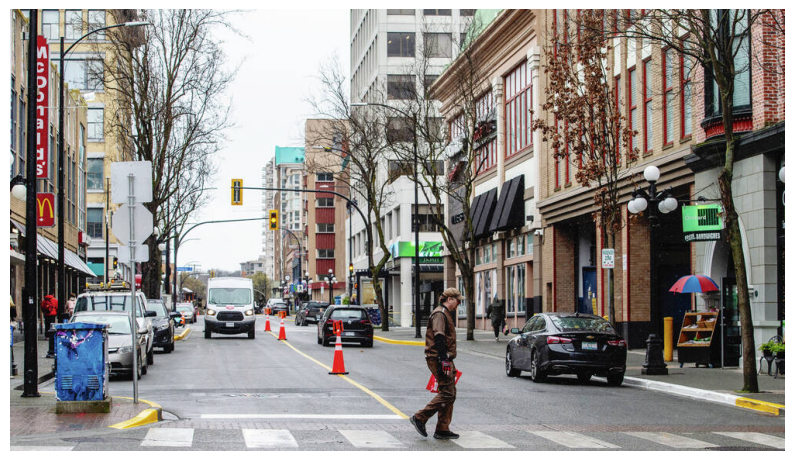

In [53]:
# Load our input image from the specified address
image = cv2.imread(IMAGE_ADDRESS)

# Convert the image from RGB to BGR color space (OpenCV uses BGR by default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Grab the spatial dimensions (height and width) of the image
H, W = image.shape[0], image.shape[1]

# Display Original Image
display_image(image)

# Object Detection Function

In [54]:
def YOLO(image, net):
    # Get the names of all the layers in the network
    ln = net.getLayerNames()
    # Get the names of the output layers (those layers that produce the final predictions)
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

    # Construct a blob from the input image and perform mean subtraction, scaling, and channel swapping
    blob = cv2.dnn.blobFromImage(image, scalefactor=1/255.0, size=(416, 416), mean=(0, 0, 0), swapRB=True, crop=False)

    # Set the blob as input to the network
    net.setInput(blob)
    
    # Perform a forward pass through the network to get the output predictions
    layerOutputs = net.forward(ln)

    # Initialize lists to store the bounding boxes, confidences, and class IDs of the detected objects
    boxes = []
    confidences = []
    classIDs = []

    # Loop over each of the layer outputs
    for output in layerOutputs:
        # Loop over each detection in the output
        for detection in output:
            # Extract the scores for each class and find the class ID with the highest score
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            # Filter out weak predictions by ensuring the confidence is greater than the threshold
            if confidence > CONFIDENCE:
                # Scale the bounding box coordinates back to the size of the original image
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                # Use the center coordinates to derive the top-left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                # Update the lists of bounding box coordinates, confidences, and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # Apply non-maxima suppression to suppress weak, overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE, THRESHOLD)

    # Ensure at least one detection exists
    if len(idxs) > 0:
        # Loop over the indexes we are keeping
        for i in idxs.flatten():
            # Extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            # Draw the bounding box rectangle and label on the image
            # Get the color for the current object's bounding box and label
            # The color is obtained from the COLORS array using the object's class ID
            color = [int(c) for c in COLORS[classIDs[i]]]

            # Draw a rectangle around the detected object on the image
            # The rectangle is defined by the top-left corner (x, y) and the bottom-right corner (x + w, y + h)
            # The color and thickness of the rectangle are specified
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)

            # Prepare the text label to display the object's class and confidence score
            # The label is formatted to include the class name and confidence score with four decimal places
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])

            # Draw the text label on the image above the bounding box
            # The text is placed at the position (x, y - 5) with the specified font type, size, color, and thickness
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Return the output image with the drawn bounding boxes and labels
    return image

# Visualizing the Result

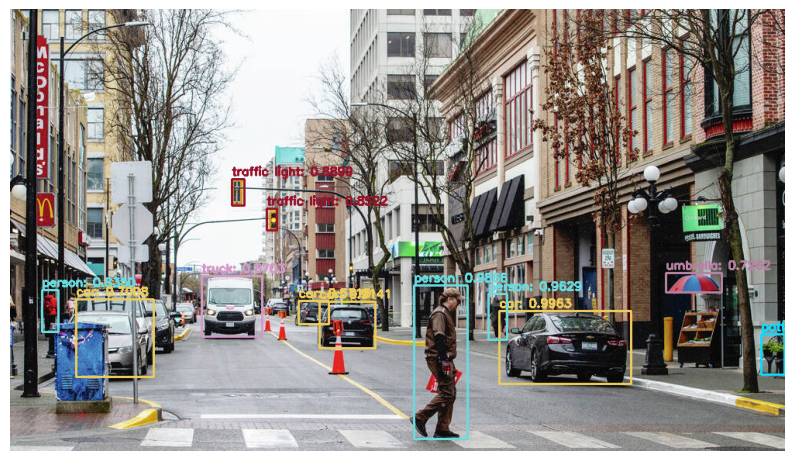

True

In [55]:
# Detect objects of the image
result = YOLO(image, net)

display_image(result)

OUTPUT_FOLDER = "outputImages"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
output_path = os.path.join(OUTPUT_FOLDER, "image1.jpg")
result_bgr = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
cv2.imwrite(output_path, result_bgr)